# Calculating the $E$ and $H$ fields generated by a magnetic source

We know that we can get the magnetic fields from the electric fields using Faraday's law, see the notebook [5a_Obtaining_the_magnetic_field](./5a_Obtaining_the_magnetic_field.ipynb).

However, what about calculating the fields generated by a magnetic source? There are two ways we can achieve that:
- using the duality principle, see the notebook [5d_Magnetic_source_using_duality](./5d_Magnetic_source_using_duality.ipynb);
- creating an electric loop source, which is what we do in this notebook.

We create a horizontal, electric loop source to generate a vertical magnetic field in a homogeneous VTI fullspace, and compare it to the semi-analytical solution of `empymod`. (The code `empymod` is an open-source code which can model CSEM responses for a layered medium including VTI electrical anisotropy, see https://empymod.github.io.)

The method used here can be applied to an arbitrarily rotated, arbitrarily shaped source loop.

#### Requires
- ``emg3d``, ``discretize``, ``empymod``
- ``numpy``, ``scipy``, ``numba``, ``matplotlib``

In [1]:
import emg3d
import empymod
import discretize
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as sint
from matplotlib.colors import LogNorm, SymLogNorm

In [2]:
# Style adjustments
%matplotlib inline
plt.style.use('ggplot')

### Plotting and interpolation routines

In [3]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map
    https://gist.github.com/jakevdp/91077b0cae40f8f8244a
    """
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


def plot_data_rel(ax, name, data, x, vmin=-15., vmax=-7., mode="log"):
    """Plot function."""
    
    ax.set_title(name)
    ax.set_xlim(min(x)/1000, max(x)/1000)
    ax.set_ylim(min(x)/1000, max(x)/1000)
    ax.axis("equal")
    
    if isinstance(mode, str):
        if mode == "abs":
            cf = ax.pcolormesh(x/1000, x/1000, np.log10(np.abs(data)), linewidth=0,
                               rasterized=True, cmap="viridis", vmin=vmin, vmax=vmax)
        else:
            cf = ax.pcolormesh(x/1000, x/1000, data, linewidth=0, rasterized=True, cmap="PuOr_r",
                               norm=SymLogNorm(linthresh=10**vmin, vmin=-10**vmax, vmax=10**vmax))
    else:
        cf = ax.pcolormesh(x/1000, x/1000, np.log10(data), vmin=vmin, vmax=vmax,
                           linewidth=0, rasterized=True, cmap=discrete_cmap(8, "RdBu_r"))

    return cf


def plot_result_rel(depm, de3d, x, title, vmin=-15., vmax=-7., mode="log"):
    fig, axs = plt.subplots(figsize=(18, 10), nrows=2, ncols=3)
    
    if mode == "log":
        case = ""
    else:
        case = "|"

    # Plot Re(data)
    cf0 = plot_data_rel(axs[0, 0], r"(a) "+case+"Re(empymod)"+case, depm.real, x, vmin, vmax, mode)
    plot_data_rel(axs[0, 1], r"(b) "+case+"Re(emg3d)"+case, de3d.real, x, vmin, vmax, mode)
    cf2 = plot_data_rel(axs[0, 2], r"(c) Error real part",
                        np.abs((depm.real-de3d.real)/depm.real)*100, x,
                        vmin=-2, vmax=2, mode=True)

    # Plot Im(data)
    plot_data_rel(axs[1, 0], r"(d) "+case+"Im(empymod)"+case, depm.imag, x, vmin, vmax, mode)
    plot_data_rel(axs[1, 1], r"(e) "+case+"Im(emg3d)"+case, de3d.imag, x, vmin, vmax, mode)
    plot_data_rel(axs[1, 2], r"(f) Error imaginary part",
                  np.abs((depm.imag-de3d.imag)/depm.imag)*100, x, vmin=-2, vmax=2, mode=True)

    # Colorbars
    fig.colorbar(cf0, ax=axs[0, :], label=r"$\log_{10}$ Amplitude (A/m)")
    cbar = fig.colorbar(cf2, ax=axs[1, :], label=r"Relative Error")
    cbar.set_ticks([-2, -1, 0, 1, 2])
    cbar.ax.set_yticklabels([r"$0.01\,\%$", r"$0.1\,\%$", r"$1\,\%$", r"$10\,\%$", r"$100\,\%$"])

    # Axis label
    fig.text(0.4, 0.05, "Inline Offset (km)", fontsize=14)
    fig.text(0.08, 0.6, "Crossline Offset (km)", rotation=90, fontsize=14)

    # Title
    fig.suptitle(title, y=1, fontsize=20)

    
def plot_lineplot_ex(x, y, data, epm_fs, grid):
    xi = x.size//2
    yi = y.size//2
    
    fn = sint.interp1d(x, data[:, xi], bounds_error=False)
    x1 = fn(grid.vectorNx)
    
    fn = sint.interp1d(y, data[yi, :], bounds_error=False)
    y1 = fn(grid.vectorNx)

    plt.figure(figsize=(15, 8))
        
    plt.plot(y/1e3, np.abs(epm_fs[yi, :]), 'C1', lw=3, label='Inline empymod')
    plt.plot(y/1e3, np.abs(data[yi, :]), 'k:', label='Inline emg3d')
    plt.plot(grid.vectorNx/1e3, np.abs(y1), 'k*', label='Grid points emg3d')

    plt.yscale('log')
    plt.title(r'Inline $H_x$', fontsize=20)
    plt.xlabel('Offset (km)', fontsize=14)
    plt.ylabel(r'|Amplitude (A/m)|', fontsize=14)
    plt.legend()
    plt.show()

## Full-space model for a finite length, finite strength, rotated bipole 

### `empymod`

In [4]:
# Survey parameters
x = (np.arange(1025))*5-2560
rx = np.repeat([x,],np.size(x),axis=0)
ry = rx.transpose()

# Model parameters
resh = 1.              # Horizontal resistivity
aniso = np.sqrt(2.)    # Anisotropy
resv = resh*aniso**2   # Vertical resistivity
src = [0, 0, -300, 0, 90]  # Source: [x, y, z, azimuth, dip]
zrec = -400.           # Receiver depth
freq = 0.77            # Frequency
strength = np.pi       # Source strength

# Input for empymod
model = {  # empymod has positive z-down, so switch source-z
    'src': [src[0], src[1], -src[2], src[3], src[4]],
    'depth': [],
    'res': resh,
    'aniso': aniso,
    'strength': strength,
    'freqtime': freq,
    'htarg': {'pts_per_dec': -1},
}

In [5]:
rxx = rx.ravel()
ryy = ry.ravel()

# e-field
epm_fs_ex = empymod.loop(rec=[rxx, ryy, -zrec, 0, 0], mrec=False, verb=3, **model).reshape(np.shape(rx))
epm_fs_ey = empymod.loop(rec=[rxx, ryy, -zrec, 90, 0], mrec=False, verb=1, **model).reshape(np.shape(rx))
epm_fs_ez = empymod.loop(rec=[rxx, ryy, -zrec, 0, -90], mrec=False, verb=1, **model).reshape(np.shape(rx))

# h-field
epm_fs_hx = empymod.loop(rec=[rxx, ryy, -zrec, 0, 0], verb=1, **model).reshape(np.shape(rx))
epm_fs_hy = empymod.loop(rec=[rxx, ryy, -zrec, 90, 0], verb=1, **model).reshape(np.shape(rx))
epm_fs_hz = empymod.loop(rec=[rxx, ryy, -zrec, 0, -90], verb=1, **model).reshape(np.shape(rx))


:: empymod START  ::

   depth       [m] :  
   res     [Ohm.m] :  1
   aniso       [-] :  1.41421
   epermH      [-] :  1
   epermV      [-] :  1
   mpermH      [-] :  1
   mpermV      [-] :  1

>  MODEL IS A FULLSPACE
   direct field    :  Calc. in wavenumber domain
   frequency  [Hz] :  0.77
   Hankel          :  DLF (Fast Hankel Transform)
     > Filter      :  Key 201 (2009)
     > DLF type    :  Lagged Convolution
   Kernel Opt.     :  None
   Loop over       :  Frequencies
   Source(s)       :  1 dipole(s)
     > x       [m] :  0
     > y       [m] :  0
     > z       [m] :  300
     > azimuth [°] :  0
     > dip     [°] :  90
   Receiver(s)     :  1050625 dipole(s)
     > x       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > y       [m] :  -2560 - 2560 : 1.05062E+06  [min-max; #]
     > z       [m] :  400
     > azimuth [°] :  0
     > dip     [°] :  0
   Required ab's   :  16
* WARNING :: Offsets < 0.001 m are set to 0.001 m!

:: empymod END; runtime = 0:00:00.420031

### `emg3d`

In [6]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = emg3d.utils.get_domain(x0=src[0], freq=0.1, min_width=20)
hz_min, zdomain = emg3d.utils.get_domain(x0=src[2], freq=0.1, min_width=20)

# Create stretched grid
nx = 2**7
hx = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src[0])
hy = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src[1])
hz = emg3d.utils.get_stretched_h(hz_min, zdomain, nx, src[2])
pgrid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
pgrid

TensorMesh: 2,097,152 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128     -4,358.71      4,505.64     20.00    166.93    1.03
   y    128     -4,358.71      4,505.64     20.00    166.93    1.03
   z    128     -4,658.71      4,205.64     20.00    166.93    1.03

## Generate the loop source field

Here we generate the magnetic source field by making an electric loop. For this we use here 360 segments, hence one segment per 1°. This is probably heavy overkill, but you need to have a decent amount of dipole elements, because an electric loop is not divergence free, so there is an error involved which gets bigger the fewer elements you use.

The created loop has a radius of $r=\pi^{-1/2}$, so the area is one square meter.

In [7]:
# Initiate a zero-valued source field.
sfield = emg3d.utils.Field(pgrid)

# Number of elements of the circle.
n = 360

# Loop over circle elements, adding them up.
for i, circ in enumerate(np.linspace(0, 2*np.pi, n+1)):
    
    # Skip first point (we need two points to create a dipole).
    if i != 0:
        # - Create dipole from previous point (circ_prev) to this point (circ).
        # - Divide the distances by sqrt(pi) to get unit area = 1 m2 (A=pi*r^2).
        src_x = np.array([np.cos(circ_prev), np.cos(circ)])/np.sqrt(np.pi)
        src_y = np.array([np.sin(circ_prev), np.sin(circ)])/np.sqrt(np.pi)

        # Add this dipole to the source field.
        sfield += emg3d.utils.get_source_field(pgrid, np.r_[src_x, src_y, src[2], src[2]], freq, strength)
        
    # Store this point as starting point for next dipole element.
    circ_prev = circ

In [8]:
# Get the model
pmodel = emg3d.utils.Model(pgrid, res_x=resh, res_z=resv, freq=freq)

# Calculate the electric field
efield = emg3d.solver.solver(pgrid, pmodel, sfield, verb=3)


:: emg3d START :: 14:11:13 ::

   MG-cycle       : 'F'                 sslsolver : False
   semicoarsening : False [0]           tol       : 1e-06
   linerelaxation : False [0]           maxit     : 50
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  : 128 x 128 x 128     => 2,097,152 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   6 ;   6 ;   6   

   [hh:mm:ss]  rel. error                  [abs. error, last/prev]   l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/     

   [14:11:27]   1.386e-02  after   1 F-cycles   [9.209e-09, 0.014]   0 0
   [14:11:40]   5.928e-04  after   2 F-cycles   [3.939e-10, 0.043]   0 0
   [14:11:53]   3.289e-05  after   3 F-cycle

## Compare the electric field generated from the magnetic source

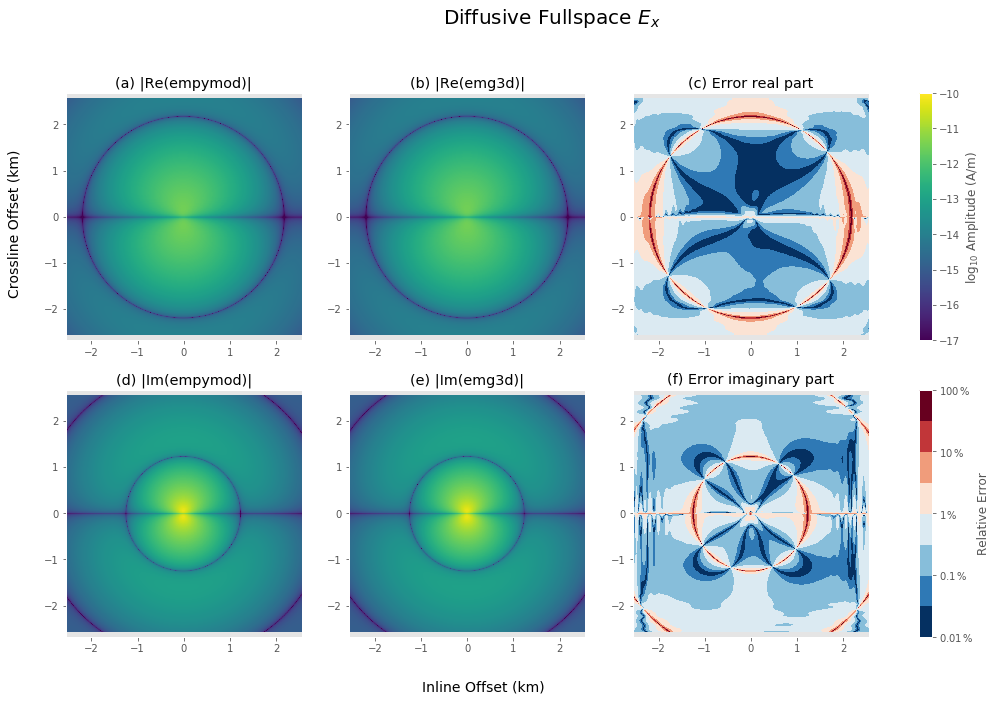

In [9]:
e3d_fs_ex = emg3d.utils.get_receiver(pgrid, efield.fx, (rx, ry, zrec))
plot_result_rel(epm_fs_ex, e3d_fs_ex, x, r'Diffusive Fullspace $E_x$', vmin=-17, vmax=-10, mode='abs')

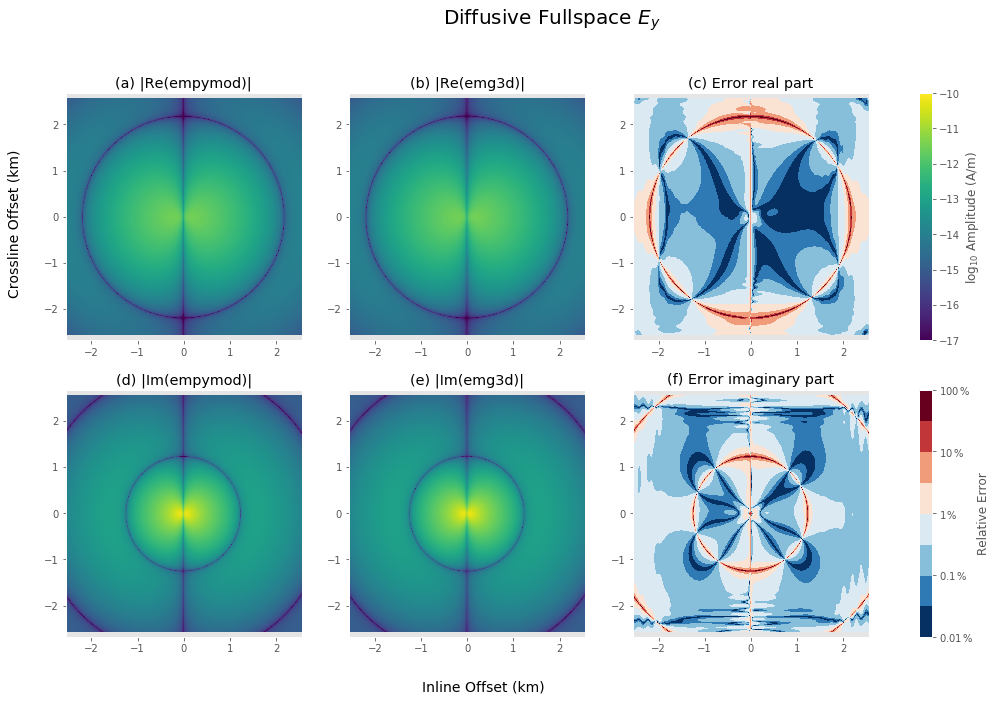

In [10]:
e3d_fs_ey = emg3d.utils.get_receiver(pgrid, efield.fy, (rx, ry, zrec))
plot_result_rel(epm_fs_ey, e3d_fs_ey, x, r'Diffusive Fullspace $E_y$', vmin=-17, vmax=-10, mode='abs')

### Diffusive Fullspace $E_z$

The $E_z$-field due to a z-directed magnetic source is zero.

## Compare the magnetic field generated from the magnetic source

### Calculate magnetic field $H$ from the electric field

In [11]:
hfield = emg3d.utils.get_h_field(pgrid, pmodel, efield)

### Plot

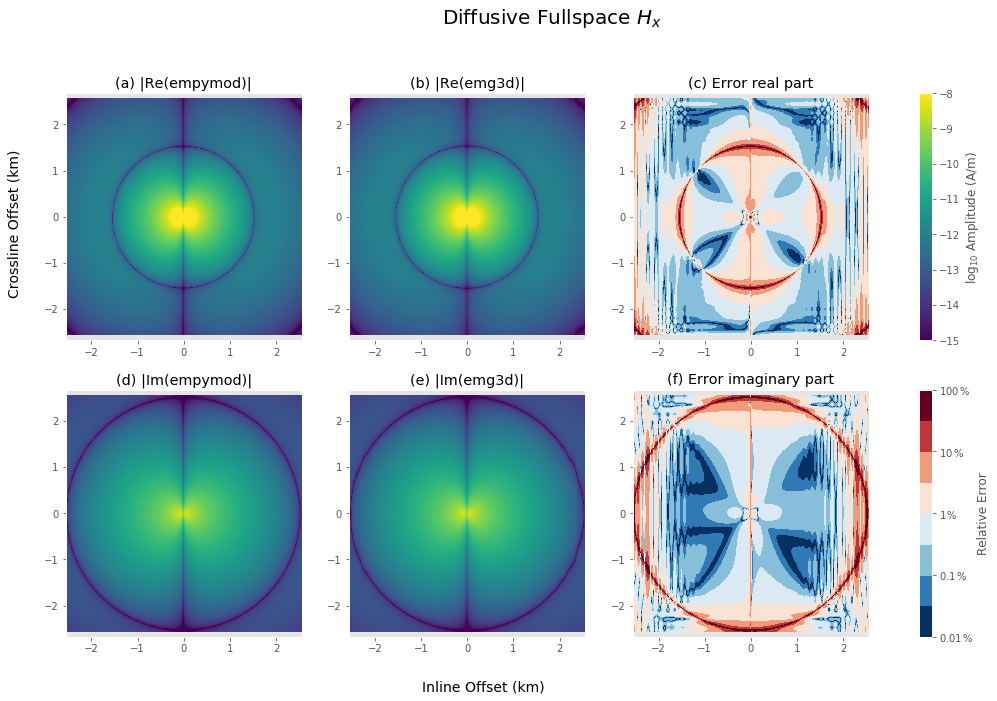

In [12]:
e3d_fs_hx = emg3d.utils.get_receiver(pgrid, hfield.fx, (rx, ry, zrec))
plot_result_rel(epm_fs_hx, e3d_fs_hx, x, r'Diffusive Fullspace $H_x$', vmin=-15, vmax=-8, mode='abs')

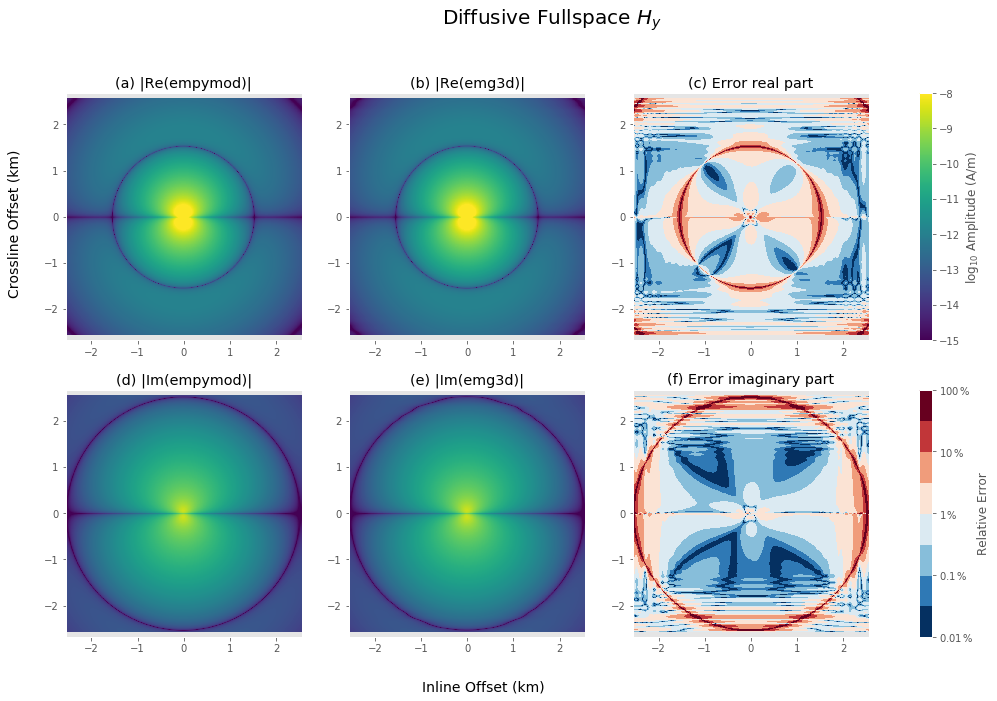

In [13]:
e3d_fs_hy = emg3d.utils.get_receiver(pgrid, hfield.fy, (rx, ry, zrec))
plot_result_rel(epm_fs_hy, e3d_fs_hy, x, r'Diffusive Fullspace $H_y$', vmin=-15, vmax=-8, mode='abs')

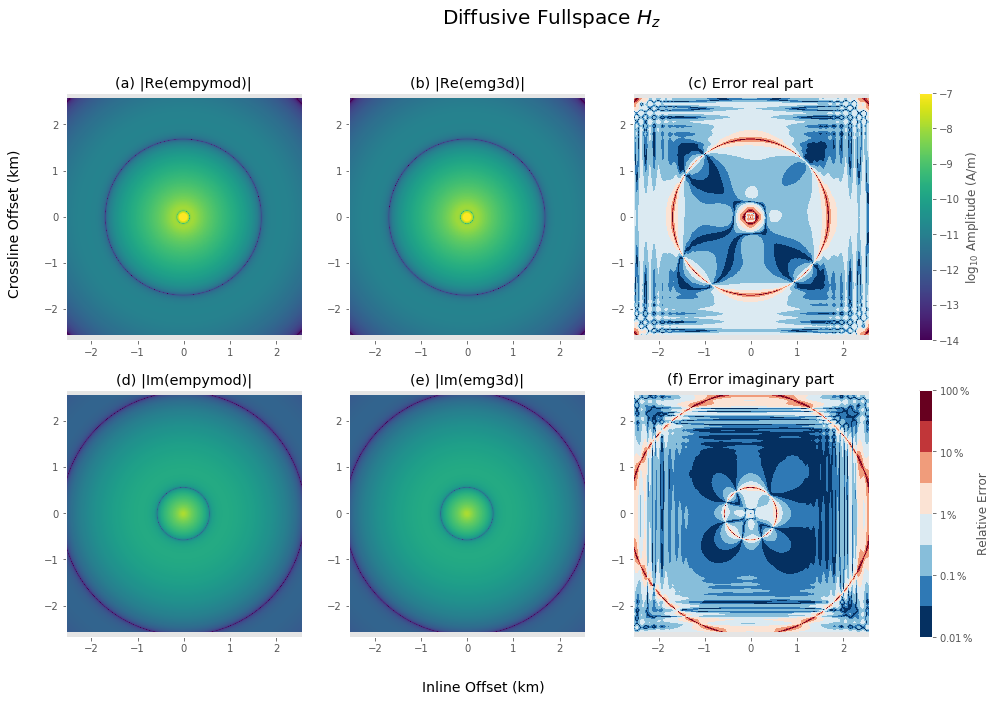

In [14]:
e3d_fs_hz = emg3d.utils.get_receiver(pgrid, hfield.fz, (rx, ry, zrec))
plot_result_rel(epm_fs_hz, e3d_fs_hz, x, r'Diffusive Fullspace $H_z$', vmin=-14, vmax=-7, mode='abs')

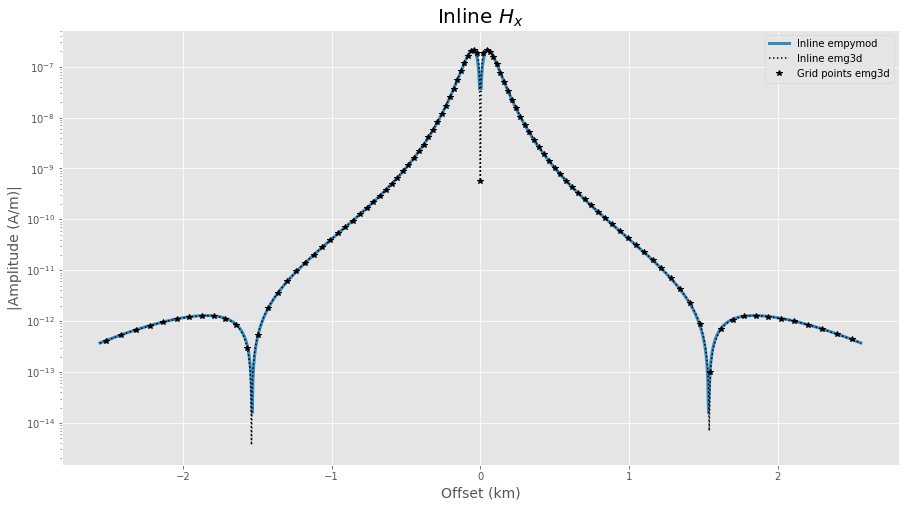

In [15]:
plot_lineplot_ex(x, x, e3d_fs_hx.real, epm_fs_hx.real, pgrid)

In [16]:
emg3d.Report(empymod)

--------------------------------------------------------------------------------
  Date: Thu Oct 24 14:13:04 2019 CEST

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
           15.5 GB : RAM
           Jupyter : Environment

  Python 3.7.4 (default, Aug 13 2019, 20:35:49)  [GCC 7.3.0]

            1.10.1 : empymod
            1.17.2 : numpy
             1.3.1 : scipy
            0.45.1 : numba
             0.8.1 : emg3d
             7.8.0 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------